<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/confirm_label_noize_for_cm_data/eras/confirm_label/analyze_results_of_KTH_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境設定

In [1]:
## import
# file dealing
import os
from os import path
import shutil
from google.colab import drive
import datetime
# data dealing
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
# process deasing
import gc
from time import sleep
# machine learning (back)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, initializers, callbacks
# machine learning
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
# others
import json
from collections import OrderedDict
import pprint
import re
from IPython.display import clear_output


#Historyデータの用意

In [2]:
## gdrive 接続
if not path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm")

## colab テンポラリディレクトリの作成
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)
print("Created at /content/desk")

Mounted at /content/drive
Created at /content/desk


In [3]:
path_KTH_Histories = "/content/drive/MyDrive/colab/histories/KTH_robust"
all_history_directories = os.listdir(path_KTH_Histories)
all_history_directories = sorted(all_history_directories)
print("Pick up one key from the below directories")
for key, each_noize_histories in enumerate(all_history_directories):
  print(each_noize_histories, "key:", key)

pick_key = int(input())

clear_output()
print("The key is", pick_key, "and", all_history_directories[pick_key])

The key is 0 and noize=0


In [4]:
path_pickup_histories = path.join(path_KTH_Histories, all_history_directories[pick_key])

each_loss_pattern = r"KTH\.(\d+\.)+\w+"


if path.isdir(path_pickup_histories):
  print("expand", path_pickup_histories)
  partial_histories = os.listdir(path_pickup_histories)
  partial_histories = sorted(partial_histories)

  count_each = 0
  each_loss_header_old = ""
  some_histories = []
  each_loss_histories = []

  for i, each_history in enumerate(partial_histories):
    each_loss_header = re.match(each_loss_pattern, each_history).group()
    if each_loss_header != each_loss_header_old and each_loss_header_old != "": # change different loss
      # update for the next loss
      count_each = 0
      some_histories.append(each_loss_histories)
      each_loss_histories = []
      print("------------------------------------------------------------------------------")

    else:
      pass
    
    the_history = pd.read_csv(path.join(path_pickup_histories, each_history))
    each_loss_histories.append(the_history)
      

    print(each_loss_header, "-", count_each+1, "@", i+1)
    count_each += 1
    each_loss_header_old = each_loss_header

    if (i+1) == len(partial_histories):
      some_histories.append(each_loss_histories)
    else:
      pass


expand /content/drive/MyDrive/colab/histories/KTH_robust/noize=0
KTH.0.CategoricalCrossentropy - 1 @ 1
KTH.0.CategoricalCrossentropy - 2 @ 2
KTH.0.CategoricalCrossentropy - 3 @ 3
KTH.0.CategoricalCrossentropy - 4 @ 4
KTH.0.CategoricalCrossentropy - 5 @ 5
KTH.0.CategoricalCrossentropy - 6 @ 6
------------------------------------------------------------------------------
KTH.0.MeanAbsoluteError - 1 @ 7
KTH.0.MeanAbsoluteError - 2 @ 8
KTH.0.MeanAbsoluteError - 3 @ 9
KTH.0.MeanAbsoluteError - 4 @ 10
KTH.0.MeanAbsoluteError - 5 @ 11
KTH.0.MeanAbsoluteError - 6 @ 12
------------------------------------------------------------------------------
KTH.0.MeanSquaredError - 1 @ 13
KTH.0.MeanSquaredError - 2 @ 14
KTH.0.MeanSquaredError - 3 @ 15
KTH.0.MeanSquaredError - 4 @ 16
KTH.0.MeanSquaredError - 5 @ 17
KTH.0.MeanSquaredError - 6 @ 18


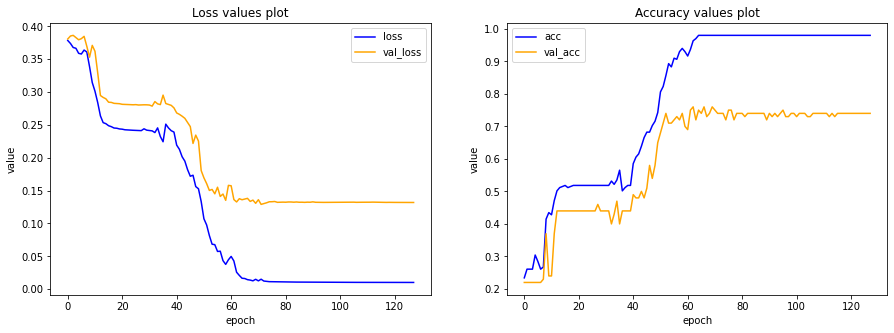

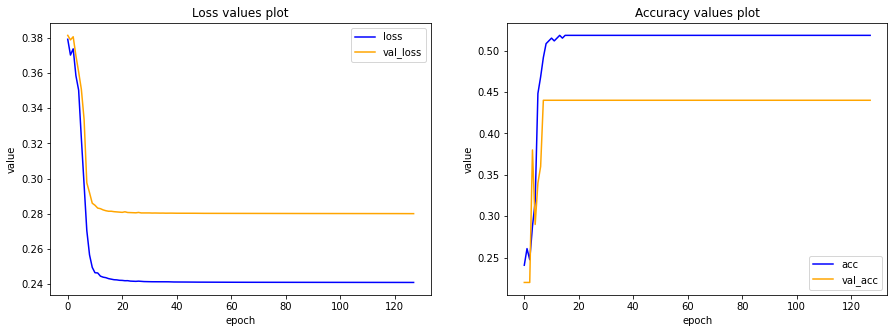

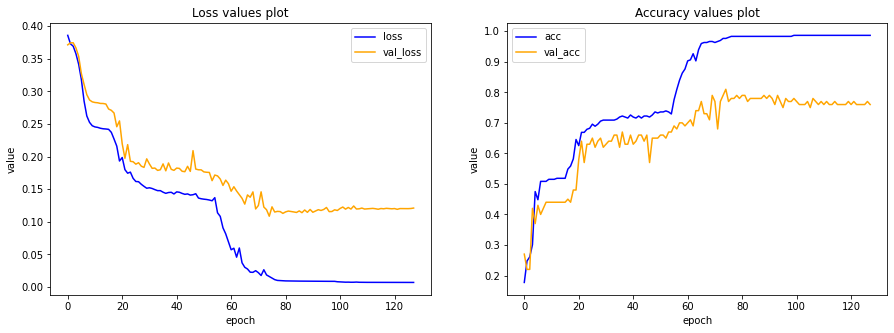

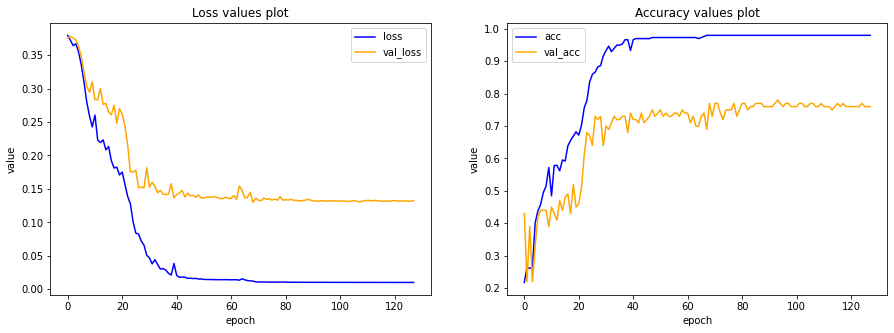

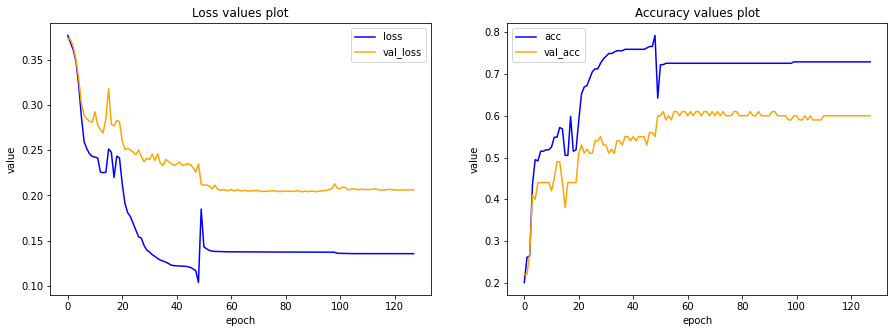

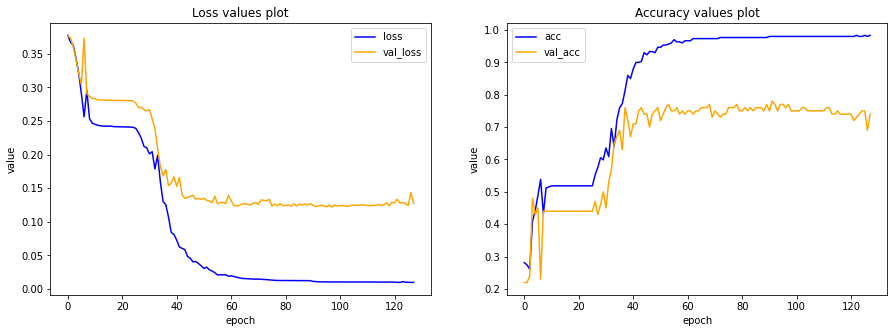

In [6]:
for i in range(6):
  plot_learning(some_histories[1][i], experiment_name="No name")

In [5]:
now_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
today = now_time.strftime('%m%d')

print(today)
def plot_learning(historyPD, experiment_name="No name"):
  HEIGHT = 1
  WIDTH = 2
  rate = 5.0
  WpH_rate = 1.5
  fig = plt.figure(figsize=(WIDTH*rate*WpH_rate, HEIGHT*rate))
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

  LOSS = fig.add_subplot(HEIGHT, WIDTH, 1) # loss, val_loss
  ACC = fig.add_subplot(HEIGHT, WIDTH, 2) # acc, val_acc

  # 1,1 loss
  loss = historyPD["loss"]
  val_loss = historyPD["val_loss"]

  loss_props = {
        'title' : 'Loss values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  LOSS.set(**loss_props)
  LOSS.plot(loss, label='loss', color='blue')
  LOSS.plot(val_loss, label='val_loss', color='orange')
  LOSS.legend(loc='best')

  # 1,2 acc
  acc = historyPD['acc']
  val_acc = historyPD['val_acc']
  acc_props = {
        'title' : 'Accuracy values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }

  ACC.set(**acc_props)
  ACC.plot(acc, label='acc', color='blue')
  ACC.plot(val_acc, label='val_acc', color='orange')
  ACC.legend(loc='best')

  #save
  image_path = path.join(desk, experiment_name+today)
  fig.savefig(image_path, bbox_inches='tight')

0122


In [ ]:
HEIGHT = 1
WIDTH = 2
rate = 5.0
WpH_rate = 1.5

fig = plt.figure(figsize=(WIDTH*rate*WpH_rate, HEIGHT*rate))

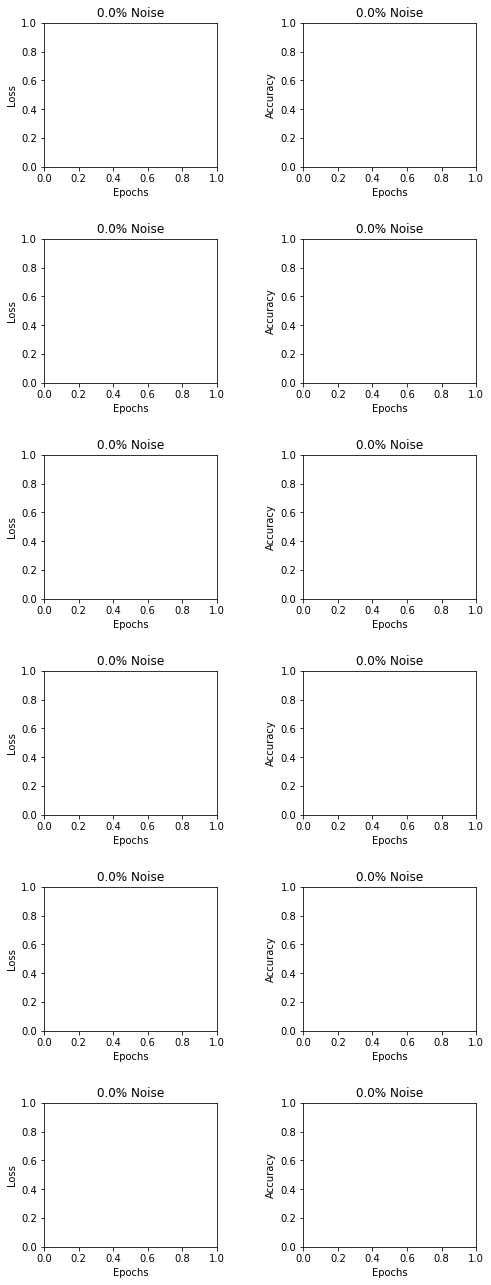

In [67]:
noize_rate = 0.0
noize_rate = str(noize_rate)

# 図のインスタンス作成
WIDTH = 8
HEIGHT = 10

fig = plt.figure(figsize=(WIDTH, HEIGHT))

## 図にグラフをプロット
k = 1
rate = 1.5  # プロットのための係数
for row in range(6):
  # LOSS part
  LOSS_plt = fig.add_subplot(6, 2, k)
  LOSS_plt.set_position([0.3*1*rate, 0.2*row*rate, 0.3, 0.2])
  LOSS_plt.set_title(noize_rate + "% Noise")
  LOSS_plt.set_xlabel('Epochs')
  LOSS_plt.set_ylabel('Loss')
  k+=1

  # ACC part
  ACC_plt = fig.add_subplot(6, 2, k)
  ACC_plt.set_position([0.3*2*rate, 0.2*row*rate, 0.3, 0.2])
  ACC_plt.set_title(noize_rate + "% Noise")
  ACC_plt.set_xlabel('Epochs')
  ACC_plt.set_ylabel('Accuracy')
  k += 1

plt.show()

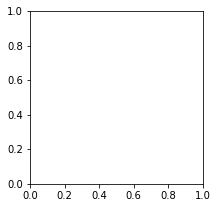

In [28]:
fig = plt.figure(figsize=(6.0, 3.0))
ax = fig.add_subplot(111)

ax.set_position([0.5,0.1,0.4,0.8])
plt.show()